In [1]:
push!(LOAD_PATH, "../../src")
using my_fcf
using Colors, Images, FileIO, Plots, Statistics, LinearAlgebra

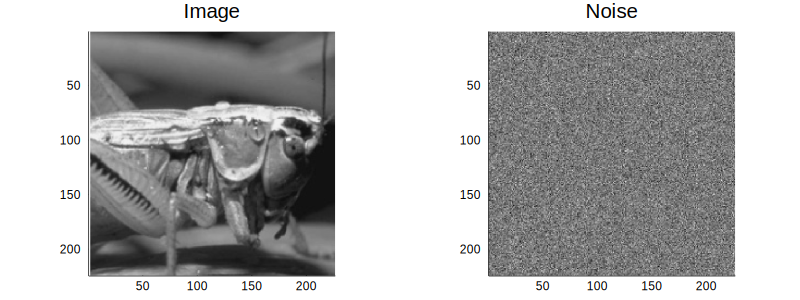

In [8]:
# import the panda image
image = "../images/locust.jpg"; # also try images/locust.jpg
I1 = Float64.(Gray.(load(image)))

# generate the white noise, match the variance
I2 = randn(size(I1))*std(I1)

# plot the original image and noise
p1 = heatmap(I1, yflip=true, color=:grays, aspect_ratio=:equal, title="Image", colorbar = false)
p2 = heatmap(I2, yflip=true, color=:grays, aspect_ratio=:equal, title="Noise", colorbar = false)
plot(p1, p2; size=(800, 300))

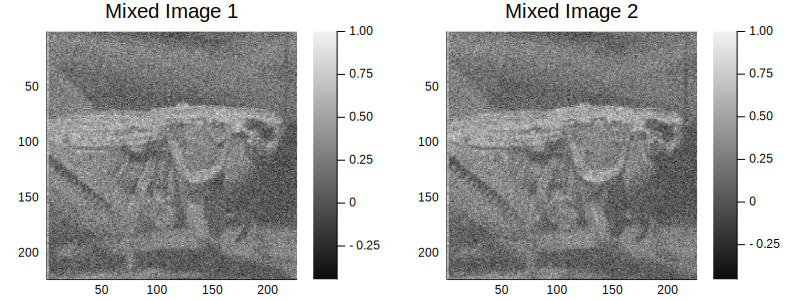

In [9]:
# Noise image
X = [I1, I2]
I1 = 0.0
I2 = 0.0 ## this clears I1 and I2 from memory

# mixing matrix
A = [0.5 0.5; 0.5 -0.5]
Z = A*X

# normalize the mixed images for plot
mixed1 = Z[1]/maximum(Z[1])
mixed2 = Z[2]/maximum(Z[2])

# plot the mixed images
p3 = heatmap(mixed1, yflip=true, color=:grays, aspect_ratio=:equal, title="Mixed Image 1")
p4 = heatmap(mixed2, yflip=true, color=:grays, aspect_ratio=:equal, title="Mixed Image 2")

# release the memory
mixed1, mixed2 = 0.0, 0.0

# show the plot
plot(p3, p4; size=(800, 300))

## Denoise image using icf

In [10]:
# using icf to denoise image
# reshape mixed images to vector
z = [vec(Z[i]) for i = 1: 2]

# apply icf
Aica, xica = icf(z)

([-0.0882223 0.133898; 0.133701 0.0885146], Array{Float64,1}[[1.47975, 1.13553, 1.24201, 2.35156, 1.0401, 0.04085, -0.511163, -0.433279, 1.64846, -0.691696  …  -1.06488, -0.483496, 0.840159, -0.0789922, 0.670366, -0.711332, -1.74391, -2.30785, -1.36448, 0.759715], [4.19357, 4.26396, 4.24218, 4.0153, 4.28347, 4.47016, 4.60067, 4.58474, 4.15907, 4.63759  …  2.5099, 2.26759, 1.92641, 2.00856, 1.76718, 1.99681, 2.13742, 2.07642, 1.68956, 1.11415]])

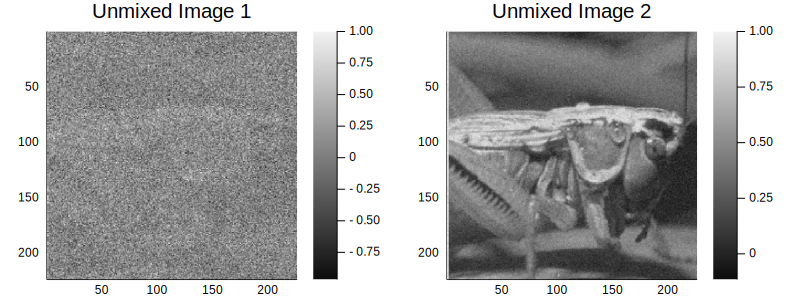

In [11]:
# normalize the unmixed images
unmixed1ica = reshape(xica[1]/maximum(xica[1]), size(Z[1]))
unmixed2ica = reshape(xica[2]/maximum(xica[2]), size(Z[1]))

# Plot the denoised image by icf, note that there is still some noise left.
p5 = heatmap(unmixed1ica, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 1")
p6 = heatmap(unmixed2ica, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 2")
plot(p5, p6; layout=2, size=(800, 300))

  2.348746 seconds (2.23 M allocations: 885.419 MiB, 8.20% gc time)


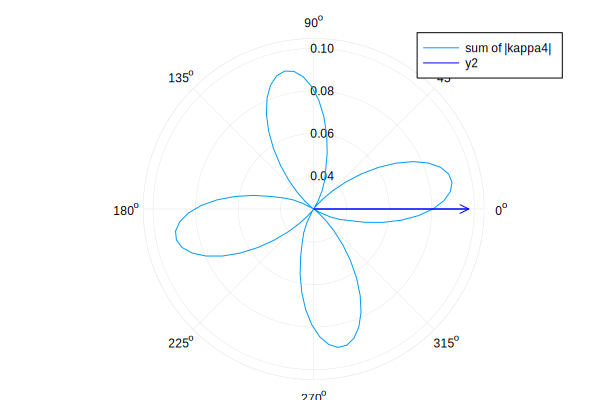

In [12]:
# the direction found by maximize sum of absolute value of free kurtosis
# does recover the independent component
# whiten the original images sepearately 
x = [vec(X[1]), vec(X[2])]
x = [x[i] .- mean(x[i]) for i = 1: 2]
x = [x[i] / std(x[i]) for i = 1: 2]

# plot the sum of absolute value of kurtosis vs theta
θ_range = range(0, stop = 2π, length = 100)
@time plot(θ -> -neg_abs_sum_kurt([cos(θ) sin(θ); -sin(θ) cos(θ)]*x), 
    θ_range, proj=:polar, label="sum of |kappa4|")
y1, y2 = ylims()
plot!([0, 0], [y1, y2], seriestype=:path, proj=:polar, arrow=0.2, color=:blue)

## Denoise image using fcf

  4.575333 seconds (7.27 M allocations: 814.678 MiB, 6.77% gc time)


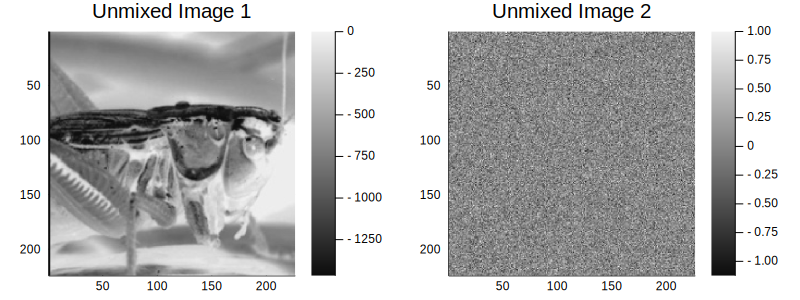

In [13]:
# Apply kurtosis-based freecf to unmix the images
@time Afca, Xfca = freecf(Z; mat_type = "rec")
 
# normalized the unmixed images 
unmixed1fca = Xfca[1]/maximum(Xfca[1])
unmixed2fca = Xfca[2]/maximum(Xfca[2])

# plot the unmixed images
p7 = heatmap(unmixed1fca, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 1")
p8 = heatmap(unmixed2fca, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 2")

unmixed1fca = 0.0
unmixed2fca = 0.0

# show the unmixed images, compare it with icf result
plot(p7, p8; layout=2, size=(800, 300))